In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression

data_a = pd.read_csv("dataset/dataset-a.csv")
data_b = pd.read_csv("dataset/dataset-b.csv")
data_c = pd.read_csv("dataset/dataset-c.csv")
data_d = pd.read_csv("dataset/dataset-d.csv")

def handle_missing_values(data):
    # Detecting missing values
    missing_values = data.isnull().sum()
    print("Missing values for each column:")
    print(missing_values)

    # Handling missing values by filling them with the median of the column
    data_filled = data.fillna(data.median())
    
    return data_filled

def handle_outliers(data, threshold=1.5):
    # Calculating IQR for each column
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Defining bounds for outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Replacing outliers with the median of the column
    for col in data.columns:
        median = data[col].median()
        data[col] = np.where((data[col] < lower_bound[col]) | (data[col] > upper_bound[col]), median, data[col])
    
    return data

def plot_actual_vs_predicted(X_test, y_test, y_predict):
    # Flatten arrays
    X_test_flat = X_test.ravel()
    y_predict_flat = y_predict.ravel()

    # Sort X_test and y_predict based on X_test
    sorted_indices = X_test_flat.argsort()
    X_test_sorted = X_test_flat[sorted_indices]
    y_predict_sorted = y_predict_flat[sorted_indices]

    plt.figure(figsize=(10,6))

    # Plot actual values as blue spots
    plt.scatter(X_test, y_test, color='blue', label='Actual Values')

    # Plot predicted values as a red line
    plt.plot(X_test_sorted, y_predict_sorted, color='red', label='Predicted Values', linewidth=2)

    plt.xlabel('X values')
    plt.ylabel('y values')
    plt.title('Actual vs Predicted Values')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

def calculate_mse(y_true, y_pred):
    mse = ((y_true - y_pred) ** 2).mean()
    print(f"Mean Squared Error: {mse:.4f}")
    return mse

handle_missing_values(data_a)
handle_outliers(data_a)
handle_missing_values(data_b)
handle_outliers(data_b)
handle_missing_values(data_c)
handle_outliers(data_c)
handle_missing_values(data_d)
handle_outliers(data_d)


Missing values for each column:
y    0
x    0
dtype: int64
Missing values for each column:
y    0
x    0
dtype: int64
Missing values for each column:
y    0
x    0
dtype: int64
Missing values for each column:
y    0
x    0
dtype: int64


,y,x
0,-1.171222,0.068870
1,-1.223282,0.061872
2,1.513045,0.987141
3,0.729461,0.941895
4,-1.177050,0.330621
...,...,...
4995,0.212240,0.504150
4996,0.944340,0.844364
4997,1.393027,0.947371
4998,0.895809,0.627815


# 2. Polynomial basis and RBF basis

In [6]:
class GaussianRBF(BaseEstimator, TransformerMixin):
    def __init__(self, p=10, s=0.5):
        self.p = p
        self.s = s
        self.centers = np.array([(i / (self.p + 1)) for i in range(1, self.p + 1)]).reshape(-1, 1)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Number of data points and number of centers
        n_samples = X.shape[0]
        n_centers = self.centers.shape[0]
        
        # Initialize transformed data with zeros
        transformed = np.zeros((n_samples, n_centers))
        
        for j, center in enumerate(self.centers):
            # Distance between each data point and the current center
            distance = np.linalg.norm(X - center, axis=1)
            
            # Apply the RBF transformation for the current center
            transformed[:, j] = np.exp(-distance**2 / (2 * self.s**2))
        
        return transformed
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        self.centers = np.array([(i / (self.p + 1)) for i in range(1, self.p + 1)]).reshape(-1, 1)
        return self
    
param_grid_poly = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

param_grid_rbf = {
    'gaussianrbf__p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'gaussianrbf__s': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

# 3 Data analysis
We will use grid search with cross-validation to choose hypermeters for p and s. Then use MSE to compare the performance for the model performance.

## 3.1 Dataset A

In [47]:
data_a.head()
x_a = np.array(data_a.x).reshape(-1, 1)
y_a = np.array(data_a.y).reshape(-1, 1)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(x_a, y_a, test_size=0.2, random_state=1234)


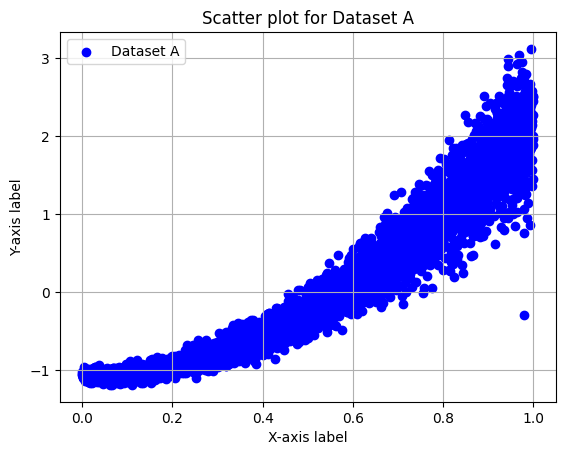

In [48]:
plt.scatter(x_a, y_a, color='blue', marker='o', label='Dataset A')
plt.title('Scatter plot for Dataset A')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.legend()
plt.grid(True)
plt.show()

Best Parameters: {'polynomialfeatures__degree': 8}
Best Cross-validation Score: -0.04832999079140717
Mean Squared Error: 0.0507


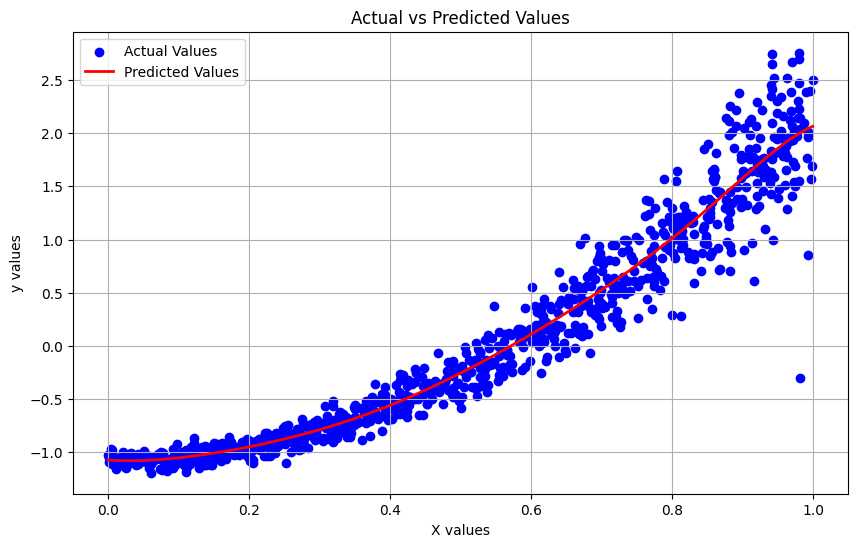

In [87]:
poly_pipeline_a = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_search_poly = GridSearchCV(poly_pipeline_a, param_grid_poly, scoring='neg_mean_squared_error', cv=5)
grid_search_poly.fit(x_a, y_a)
print("Best Parameters:", grid_search_poly.best_params_)
print("Best Cross-validation Score:", grid_search_poly.best_score_)

grid_search_poly_best = make_pipeline(
    PolynomialFeatures(degree=grid_search_poly.best_params_["polynomialfeatures__degree"]),
    LinearRegression())
grid_search_poly_best.fit(X_train_a, y_train_a)
y_predict = grid_search_poly_best.predict(X_test_a)


calculate_mse(y_test_a, y_predict)
plot_actual_vs_predicted(X_test_a, y_test_a, y_predict)

Best Parameters: {'gaussianrbf__p': 8, 'gaussianrbf__s': 0.2}
Best Cross-validation Score: -0.04830880580965942
Mean Squared Error: 0.0507


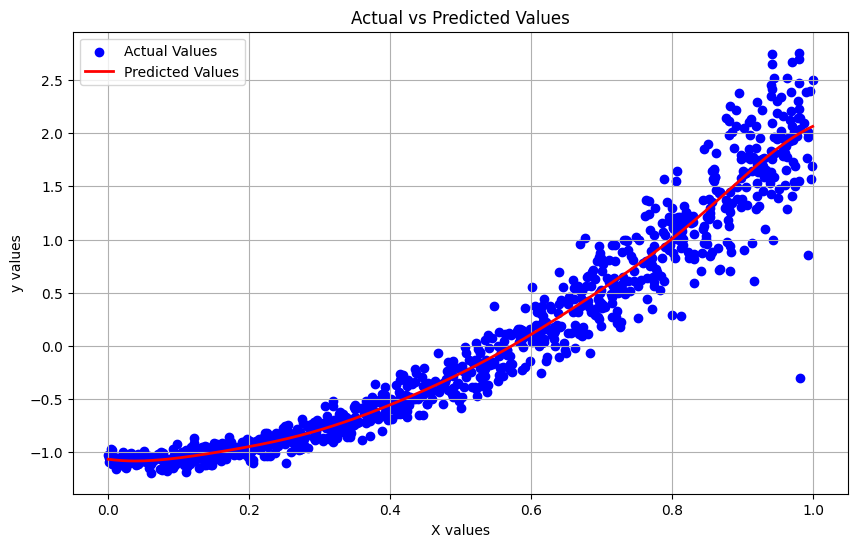

In [88]:
rbf_pipeline = make_pipeline(GaussianRBF(), LinearRegression())
grid_search_rbf = GridSearchCV(rbf_pipeline, param_grid_rbf, scoring='neg_mean_squared_error', cv=5)
grid_search_rbf.fit(x_a, y_a)
print("Best Parameters:", grid_search_rbf.best_params_)
print("Best Cross-validation Score:", grid_search_rbf.best_score_)

grid_search_RBF_best = make_pipeline(
    GaussianRBF(s=grid_search_rbf.best_params_["gaussianrbf__s"], p=grid_search_rbf.best_params_["gaussianrbf__p"]),
    LinearRegression())
grid_search_RBF_best.fit(X_train_a, y_train_a)
y_predict = grid_search_RBF_best.predict(X_test_a)

calculate_mse(y_test_a, y_predict)
plot_actual_vs_predicted(X_test_a, y_test_a, y_predict)

## 3.2 Dataset B

In [65]:
data_b.head()
x_b = np.array(data_b.x).reshape(-1, 1)
y_b = np.array(data_b.y).reshape(-1, 1)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(x_b, y_b, test_size=0.2, random_state=1234)


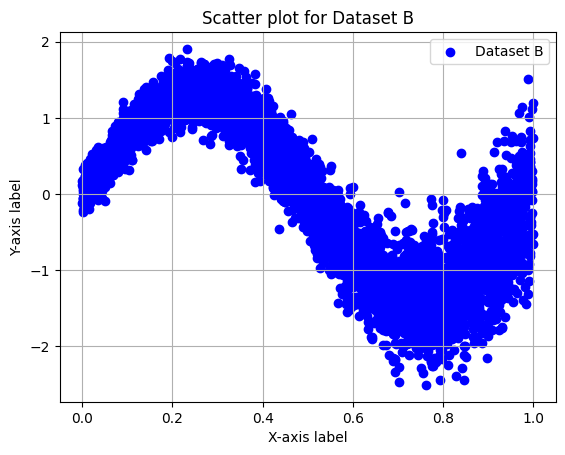

In [66]:
plt.scatter(x_b, y_b, color='blue', marker='o', label='Dataset B')
plt.title('Scatter plot for Dataset B')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
poly_pipeline_b = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_search_poly = GridSearchCV(poly_pipeline_b, param_grid_poly, scoring='neg_mean_squared_error', cv=5)
grid_search_poly.fit(x_b, y_b)
print("Best Parameters:", grid_search_poly.best_params_)
print("Best Cross-validation Score:", grid_search_poly.best_score_)

Best Parameters: {'polynomialfeatures__degree': 8}
Best Cross-validation Score: -0.10671996292759038


Mean Squared Error: 2.0449


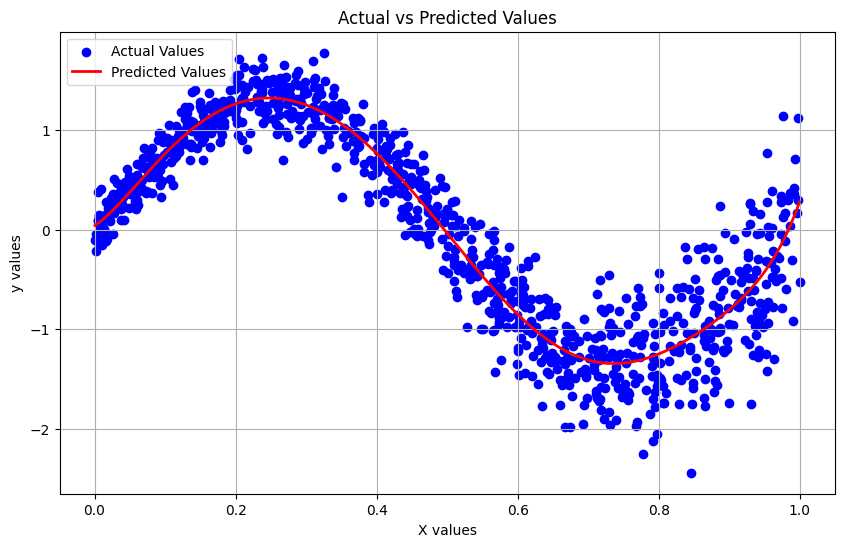

In [89]:
grid_search_poly_best = make_pipeline(
    PolynomialFeatures(degree=grid_search_poly.best_params_["polynomialfeatures__degree"]),
    LinearRegression())
grid_search_poly_best.fit(X_test_b, y_test_b)
y_predict_b = grid_search_poly_best.predict(X_test_b)

calculate_mse(y_test_b, y_predict)
plot_actual_vs_predicted(X_test_b, y_test_b, y_predict_b)

Best Parameters: {'gaussianrbf__p': 7, 'gaussianrbf__s': 0.4}
Best Cross-validation Score: -0.1067153827870013
Mean Squared Error: 0.0977


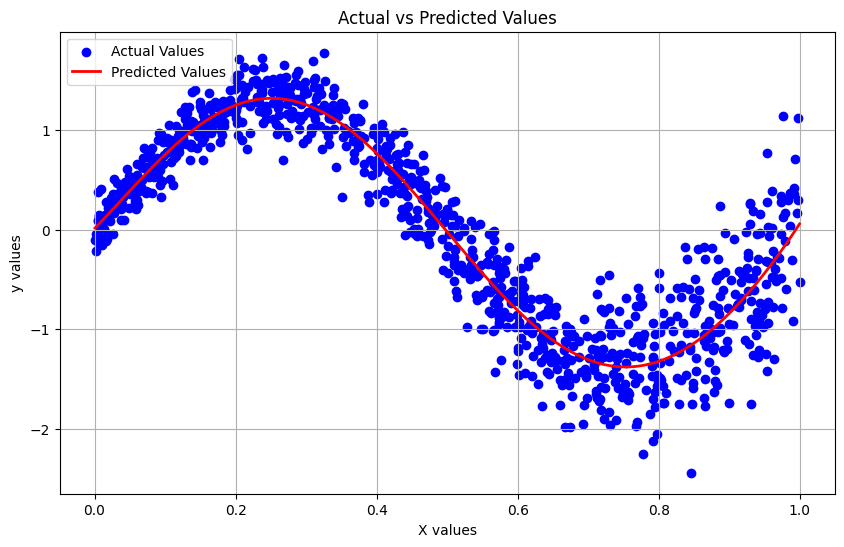

In [90]:
rbf_pipeline = make_pipeline(GaussianRBF(), LinearRegression())
grid_search_rbf = GridSearchCV(rbf_pipeline, param_grid_rbf, scoring='neg_mean_squared_error', cv=5)
grid_search_rbf.fit(x_b, y_b)
print("Best Parameters:", grid_search_rbf.best_params_)
print("Best Cross-validation Score:", grid_search_rbf.best_score_)

grid_search_RBF_best = make_pipeline(
    GaussianRBF(s=grid_search_rbf.best_params_["gaussianrbf__s"], p=grid_search_rbf.best_params_["gaussianrbf__p"]),
    LinearRegression())
grid_search_RBF_best.fit(X_train_b, y_train_b)
y_predict = grid_search_RBF_best.predict(X_test_b)

calculate_mse(y_test_b, y_predict)
plot_actual_vs_predicted(X_test_b, y_test_b, y_predict)

## 3.3 Dataset C

In [72]:
data_c.head()
x_c = np.array(data_c.x).reshape(-1, 1)
y_c = np.array(data_c.y).reshape(-1, 1)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x_c, y_c, test_size=0.2, random_state=1234)


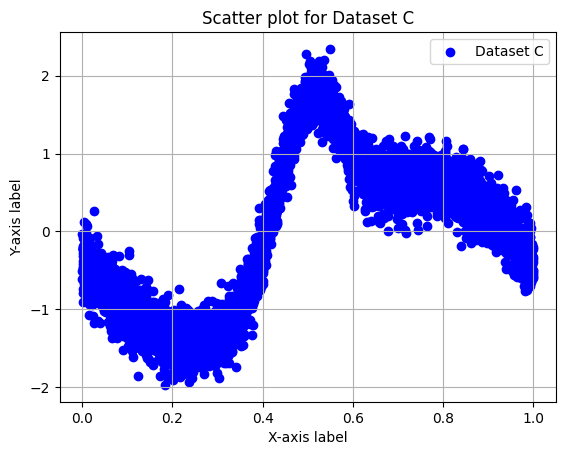

In [73]:
plt.scatter(x_c, y_c, color='blue', marker='o', label='Dataset C')
plt.title('Scatter plot for Dataset C')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.legend()
plt.grid(True)
plt.show()

Best Parameters: {'polynomialfeatures__degree': 10}
Best Cross-validation Score: -0.05453738093995789
Mean Squared Error: 1.8186


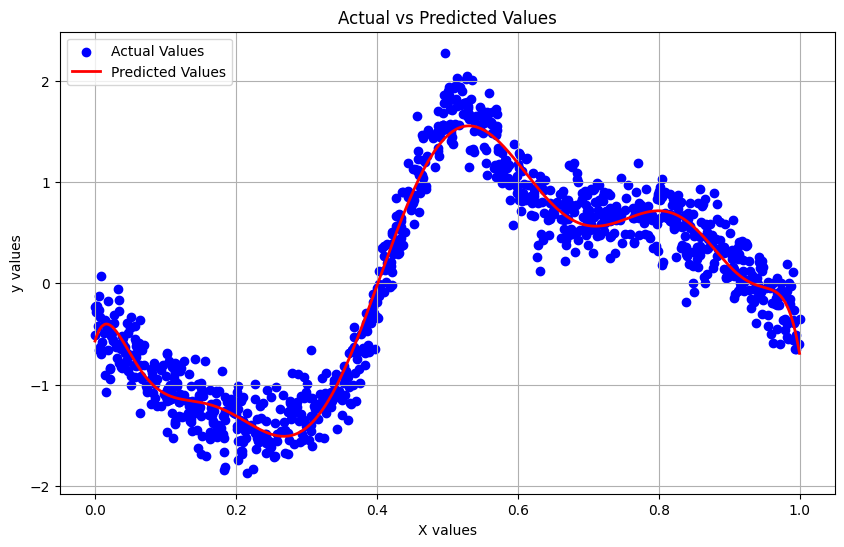

In [91]:
poly_pipeline_c = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_search_poly = GridSearchCV(poly_pipeline_c, param_grid_poly, scoring='neg_mean_squared_error', cv=5)
grid_search_poly.fit(x_c, y_c)
print("Best Parameters:", grid_search_poly.best_params_)
print("Best Cross-validation Score:", grid_search_poly.best_score_)

grid_search_poly_best = make_pipeline(
    PolynomialFeatures(degree=grid_search_poly.best_params_["polynomialfeatures__degree"]),
    LinearRegression())
grid_search_poly_best.fit(X_test_c, y_test_c)
y_predict_c = grid_search_poly_best.predict(X_test_c)

calculate_mse(y_test_c, y_predict)
plot_actual_vs_predicted(X_test_c, y_test_c, y_predict_c)

Best Parameters: {'gaussianrbf__p': 10, 'gaussianrbf__s': 0.1}
Best Cross-validation Score: -0.04499388859655333
Mean Squared Error: 0.0455


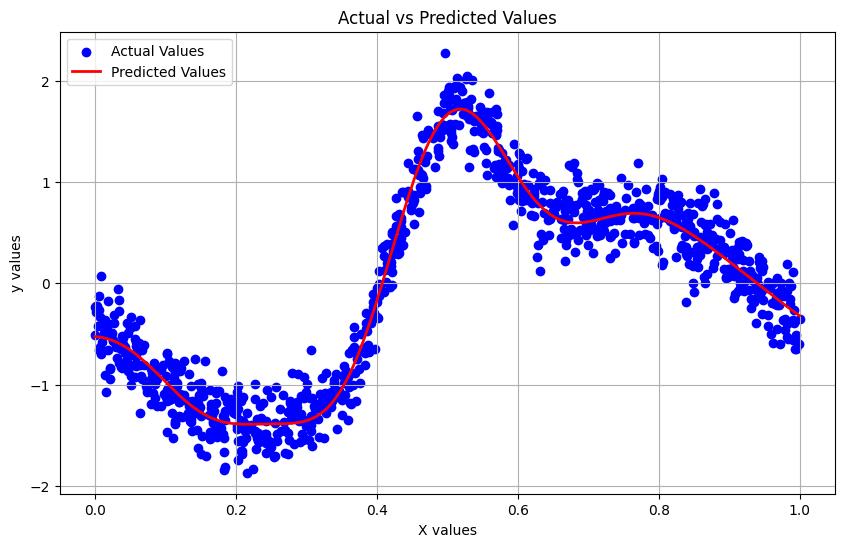

In [92]:
rbf_pipeline = make_pipeline(GaussianRBF(), LinearRegression())
grid_search_rbf = GridSearchCV(rbf_pipeline, param_grid_rbf, scoring='neg_mean_squared_error', cv=5)
grid_search_rbf.fit(x_c, y_c)
print("Best Parameters:", grid_search_rbf.best_params_)
print("Best Cross-validation Score:", grid_search_rbf.best_score_)

grid_search_RBF_best = make_pipeline(
    GaussianRBF(s=grid_search_rbf.best_params_["gaussianrbf__s"], p=grid_search_rbf.best_params_["gaussianrbf__p"]),
    LinearRegression())
grid_search_RBF_best.fit(X_train_c, y_train_c)
y_predict = grid_search_RBF_best.predict(X_test_c)

calculate_mse(y_test_c, y_predict)
plot_actual_vs_predicted(X_test_c, y_test_c, y_predict)

## 3.4 Dataset D

In [75]:
data_d.head()
x_d = np.array(data_d.x).reshape(-1, 1)
y_d = np.array(data_d.y).reshape(-1, 1)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x_d, y_d, test_size=0.2, random_state=1234)

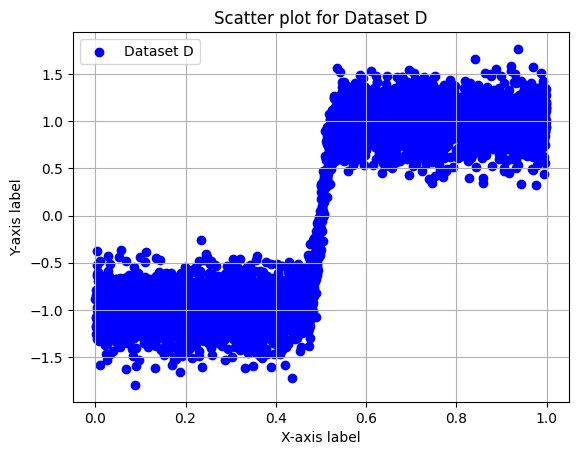

In [95]:
plt.scatter(x_d, y_d, color='blue', marker='o', label='Dataset D')
plt.title('Scatter plot for Dataset D')
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.legend()
plt.grid(True)
plt.show()

Best Parameters: {'polynomialfeatures__degree': 9}
Best Cross-validation Score: -0.07175231501557644
Mean Squared Error: 0.0521


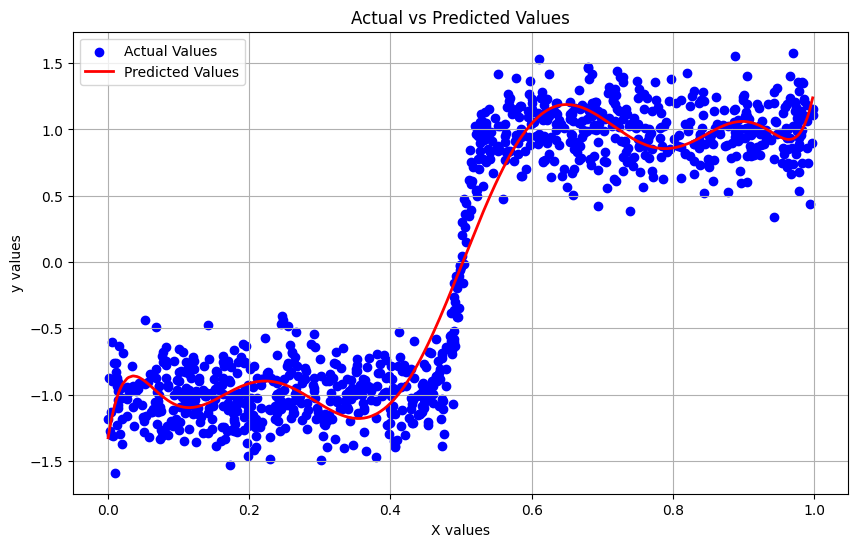

In [96]:
poly_pipeline_d = make_pipeline(PolynomialFeatures(), LinearRegression())
grid_search_poly = GridSearchCV(poly_pipeline_d, param_grid_poly, scoring='neg_mean_squared_error', cv=5)
grid_search_poly.fit(x_d, y_d)
print("Best Parameters:", grid_search_poly.best_params_)
print("Best Cross-validation Score:", grid_search_poly.best_score_)

grid_search_poly_best = make_pipeline(
    PolynomialFeatures(degree=grid_search_poly.best_params_["polynomialfeatures__degree"]),
    LinearRegression())
grid_search_poly_best.fit(X_test_d, y_test_d)
y_predict_d = grid_search_poly_best.predict(X_test_d)

calculate_mse(y_test_d, y_predict)
plot_actual_vs_predicted(X_test_d, y_test_d, y_predict_d)

Best Parameters: {'gaussianrbf__p': 10, 'gaussianrbf__s': 0.1}
Best Cross-validation Score: -0.05018494893898344
Mean Squared Error: 0.0521


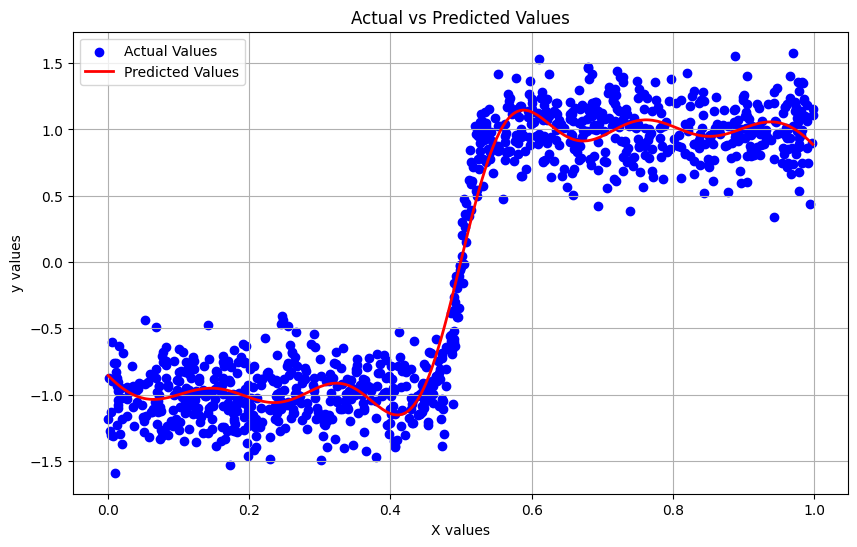

In [94]:
rbf_pipeline = make_pipeline(GaussianRBF(), LinearRegression())
grid_search_rbf = GridSearchCV(rbf_pipeline, param_grid_rbf, scoring='neg_mean_squared_error', cv=5)
grid_search_rbf.fit(x_d, y_d)
print("Best Parameters:", grid_search_rbf.best_params_)
print("Best Cross-validation Score:", grid_search_rbf.best_score_)

grid_search_RBF_best = make_pipeline(
    GaussianRBF(s=grid_search_rbf.best_params_["gaussianrbf__s"], p=grid_search_rbf.best_params_["gaussianrbf__p"]),
    LinearRegression())
grid_search_RBF_best.fit(X_train_d, y_train_d)
y_predict = grid_search_RBF_best.predict(X_test_d)

calculate_mse(y_test_d, y_predict)
plot_actual_vs_predicted(X_test_d, y_test_d, y_predict)